# Grade: /100 pts

# Assignment 04: Confidence Intervals & The Bootstrap

Once you are finished, ensure to complete the following steps.
1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.
2.  Fix any errors which result from this.
3.  Repeat steps 1. and 2. until your notebook runs without errors.
4.  Submit your completed notebook to OWL by the deadline.

In [1]:
# Add the necessary imports for this homework
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
from scipy.stats import t

### Question 1: /10pts

In this question, you will construct a confidence interval for the sample mean, not using the normal distribution, but the t-distribution (see end of lecture 4.3), which is more accurate for small sample sizes.

The $100(1-\alpha)\%$ confidence interval is

$$ \bar{x} \pm  t_{1-\alpha/2, n-1} \dfrac{\hat{\sigma}}{\sqrt{n}} $$

Where $ t_{1-\alpha/2, n-1}$ is the appropiorate quantile of a Student's t distribution with $n-1$ degrees of freedom.
Write a function called `confidence_interval` which takes as it's argument an array of data called `data` and returns two things:

* An estimated mean of `data`, and

* The lower and upper bounds of the 90% confidence interval for the mean of `data`. Ensure these are returned in a numpy array of shape (2,)

To get the appropriate quantiles for the t-distribution, you can use `scipy.stats.t`, which implements some statistical functions for the t-distribution. Take a look at the documentation for `scipy.stats.t`, especially the `ppf` method.

Here is the documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html

In [2]:
def confidence_interval(data):

    # Note, np.std divides by n and not n-1
    # Force it to apply the correct formula by ussing ddof = 1
    # Alternaively, you can use scipy.stats.sem to compute
    # The standard error
    
    
    stderr = np.std(data, ddof=1)/np.sqrt(len(data)) # compute standard error
    t_quantile = t.ppf(1 - 0.10 / 2, df = len(data) - 1) # gets critical value for t distribution
    
    bounds = data.mean() + t_quantile * stderr * np.array([-1, 1]) # compute CI bounds
    
    # Look over this, its probably wrong
    estimated_mean = (bounds[0] + bounds[1])/2

    return estimated_mean, bounds

### Question 2: /15pts

The "90% confidence interval" is named so because the long term relative frequency of these estimators containing the true estimand is 90%. That is to say "if I construct 100 90% confidence intervals for the sample mean again and again from the same data generating mechanism, 90 of these intervals that I construct will contain the true population mean".

Write a function called `ci_simulation` that runs some simulations to show this is the case. From a standard normal distribution, sample 25 observations and construct a confidence interval. Do this 20 times and plot the intervals using `matplotlib.pyplot.errorbar`. Color the bar red if the confidence interval does not capture the true mean and blue if it does. If you are unfamiliar with `matplotlib.pyplot.errorbar`, I highly suggest reading Matplotlib's excellent documentation which has some examples at the bottom of the webpage.

If you are unfamiliar with how to sample random numbers, I suggest you look at `numpy.random.normal`. Try searching for the documentation for that function yourself if you need to.

Here is the documentation for `matplotlib.pyplot.errorbar`: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html

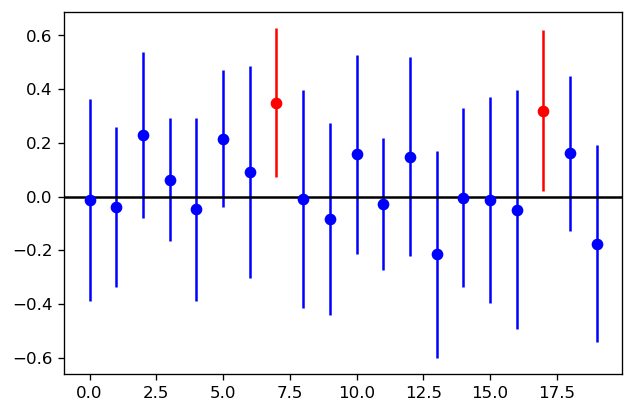

In [3]:
def ci_simulation():
    # Set the random seed to always get the same random numbers.
    # This is for Reproducibility.
    np.random.seed(1)
    
    # Create the figure.
    fig, ax = plt.subplots(dpi = 120)

    # If the interval crosses this line, it should be blue, else red.
    ax.axhline(0, color = 'k')

    # Do the following 20 times
    for i in range(20):
        # Draw 25 observations from a standard normal
        normData = np.random.normal(size = 25)
        
        # Compute what we need for the CI, namely the mean and the bounds
        mean, bounds = confidence_interval(normData)
        
        # color should be blue if it crosses the black line
        color = 'blue'
        if (min(bounds) > 0) | (max(bounds) < 0):
            # but in the case it does not, turn it red
            color = 'red'

        # Need to get the length of the interval from bounds
        interval_len = 1 / 2 * (bounds[1] - bounds[0])
        ax.errorbar(i, mean, yerr = interval_len, color = color, fmt = 'o')

    # This function does not have to return anything
    return None

ci_simulation()

### Question 3: /8pts

If you haven't changed the random seed from 1 and if you implemented the solution correctly, you should see two red intervals.

Answer the following below in no more than 3 sentences:

a) We should expect to see two red lines. Why? Explain why this is the expected value.

Changing the random seed might affect how many red intervals you see. Try changing the random seed in your function to 2. This will yield three red intervals (which is different from what you should expect to see).

b) Why does the simulation sometimes deviate from the predicted results?

**Written answer:**

a) By definition of 90% confidence interval, it is expected that 90% of intervals generated will contain the true population statistic. In our case we simulated 20 different intervals, thus it was expected that 90% of 20 (18) would contain true statistic and 10% of 20 (2) would not. Thus it is expected to have 2 red lines.

b)Due to the randomness of the sampling.

### Question 4: /10pts

Load in the `auto.csv` data using Pandas. It contains data for different cars, including their name, origin, fuel consumption (mpg), weight, and horsepower.

Fit a linear model of mpg explained by weight using a simple linear regression model from sklearn, as done in the lab and assignment 1 (you can use the LinearRegression function). Call your fitted model `model`.

Make a scatter plot of the weight (x-axis) against mpg (y-axis). Make sure to label the plot axes.
Add the predicted values for weights between 1500 and 5500 as a line plot.
Calculate the residuals from the fit and report the r-squared for this model.
Report the coefficient and the intercept for this model.

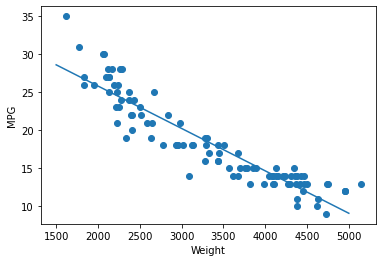

R-squared: 0.858


In [4]:
df = pd.read_csv('auto.csv')

# Create and fit the model
model = sklearn.linear_model.LinearRegression()

# Make the scatter plot
plt.scatter(x = df.weight, y = df.mpg)
plt.xlabel("Weight")
plt.ylabel("MPG")

# Generate and plot the predicted values
y = df.mpg
X = np.c_[df.weight]
model.fit(X,y)

p_Weight = np.linspace(1500,5000,100)
X_pred = np.c_[p_Weight]
p_MPG = model.predict(X_pred)
plt.plot(p_Weight, p_MPG)
plt.show()

# Calculate R2
R_sq = model.score(X,y) 
print("R-squared: %.3f" %R_sq)


In [5]:
# Print the coefficient and the intercept
print("Coefficient:",model.coef_)
print("Intercept: %.3f" %model.intercept_)

Coefficient: [-0.00557896]
Intercept: 36.980


### Question 5:  /15pts
### Bootstrap confidence intervals on parameters

How confident can we be about the relation between weight and mpg?
To judge this we need confidence intervals. Let's use the bootstrap.

Modify the function `BootstrapCoef` from lab 04 - part 2 to conduct a boostrap analysis for this regression model. As a few hints:

* `data`, is a dataframe having columns 'mpg' and 'weight'
* `numboot` is an integer denoting how many bootstrap replications to perform.

Write the function `bootstrap` to perform bootstrap resampling. You can use `pd.DataFrame.sample` with `replace = True` to perform the resampling. `bootstrap` should return a numpy array ```params``` of size ```[numboot, numParams]``` of bootstraped parameter values. The parameters are the intercept value and the slope from the linear regression.


*Tip: Note that the intercept can be retrieved from model.intercept_, whereas all the other regression coefficients are stored in model.coef_.*

Here is the documentation for `pd.DataFrame.sample`: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

Then call the function to get 1000 boostrap samples for your linear regression model of mpg explained by weight.

Make a joint scatter plot of the parameter value for the intercept and for the slope.

**Written answer:** What do you notice? Why do you think the estimate for the intercept has such a high negative correlation with the slope?

In [6]:
# Write a Bootstrap function that records the fitted models
def BootstrapCoef(data, numboot):
    # Write the function here
    
    n = len(data)
    params = np.zeros((numboot,2))    
    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = np.c_[d.weight] # , d.weight**2, d.weight**3
        model.fit(X_fit, d.mpg)
        params[i,0] = model.coef_
        params[i,1] = model.intercept_
    return params

# Run the function over your data
paramsBS = BootstrapCoef(df, 1000)
display(paramsBS)

array([[-5.58299126e-03,  3.73529518e+01],
       [-5.66483661e-03,  3.73660881e+01],
       [-5.56694591e-03,  3.72118874e+01],
       ...,
       [-5.57993588e-03,  3.72405131e+01],
       [-5.52137223e-03,  3.68987631e+01],
       [-5.70876807e-03,  3.71062813e+01]])

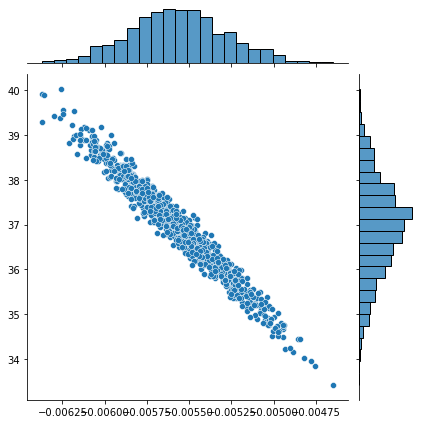

In [7]:
# Make the scatterplot

sns.jointplot(x=paramsBS[:,0], y=paramsBS[:,1])
plt.xlabel("Slope")
plt.ylabel("Intercept")
plt.show()

**Written answer:**
Over estimating the intercept results in underestimating the slope. This is due to the fit line trending towards the bulk of the data. If it starts high it compensates by having a more negative slope.

### Question 6: /12pts

Plot the bootstrap estimates for the slope as a histogram. Use your samples to compute a 90% confidence interval. Note that the CI should be constructed around the sample estimate of the slope. How can you interpret this confidence interval?

Boot ci: [-0.0060486  -0.00508005]


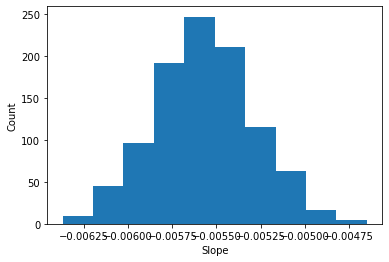

In [8]:
# Plot histogram
slopes = paramsBS[:,0]

plt.hist(slopes)
plt.ylabel("Count")
plt.xlabel("Slope")

# Compute the CI


boot_ci = np.zeros(2)
    
boot_ci[0] = np.percentile(slopes, 5) # lower bound    
boot_ci[1] = np.percentile(slopes, 95) # upper bound

print("Boot ci:",boot_ci)


**Written answer:** 
If we were to construct infinite models from infinite different samples. We expect that the true slope will fall within thise interval 90% of the time.


### Question 7: /15pts

Modify the function `BootstrapPred` from lab04 to bootstrap your fit and generate a prediction from each of these bootstrapped models.

Draw again a scatter plot of weight against mpg and plot the predictions from the 20 fitted bootstrap models for the weights ranging from 1500 to 5500. Draw all these lines onto your scatter plot.

Written answer: Where are we most uncertain in our prediction about the mpg of a car? How does the negative correlation between slope and intercept play a role here? Why is the spread of the predictions in the middle weights lower?

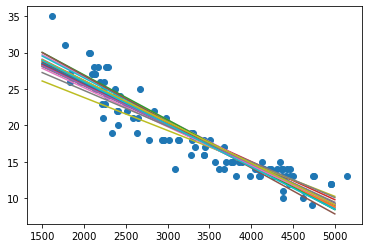

In [9]:
# Write a Bootstrap function that records the fitted models
def BootstrapPred(data, xp):

    numboot = 1000
    n = len(data)
    X_pred = np.c_[xp] # , xp**2, xp**3
    y_pred = np.zeros((numboot,X_pred.shape[0]))    

    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = np.c_[d.weight] # , d.weight**2, d.weight**3
        model.fit(X_fit,d.mpg)
        y_pred[i,:] = model.predict(X_pred)
    
    return y_pred

# Get predictions from 20 bootstrapped models
y_pred = BootstrapPred(df, p_Weight)


# Make a scatterplot and draw the 20 lines
plt.scatter(df.weight, df.mpg)
for i in range(20):
    plt.plot(p_Weight, y_pred[i,:])

**Written answer:**
We are most uncertain at the ends of the data points. Due to the negative correlation between slope and intercept, the fit lines with a higher intercept decrease faster and the ones with a lower intercept decrease slower. This results in the spread of the predictions near the middle to be much smaller than the predictions on the ends. 

### Question 8:  /15pts

Now, let's see how well our model performs out of sample. Load the `auto_test.csv` file into a dataframe. Use your fitted `model` to make predictions on the test data. Do not refit your model using the test data. Calculate and report the r-squared value for the test data (`r_squared_test`).

Write a function `BootstrapR2` that takes as its arguments `data` and `numboot` and returns a numpy array of size ```[numboot, 1]``` of bootstraped parameter values. The parameter is the r-squared value of the predictions made by `model` on the test data. Run the function with `numboot` set to 1000 and report a 90% confidence interval for this r-squared. Note that the CI should be constructed around `r_squared_test`.

Written answer: Compare `r_squared_test` with the r-squared obtained in Question 4. What can you conclude? What might explain the lower performance of `model` on the test data?

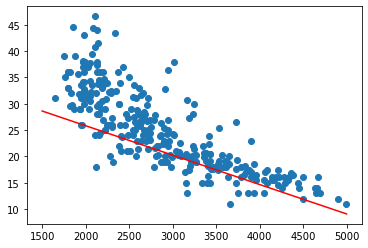

R-squared: 0.329


In [10]:
# Compute r_squared_test
df_test = pd.read_csv('auto_test.csv')

y_test = df_test.mpg
X_test = np.c_[df_test.weight]

plt.scatter(df_test.weight, y_test)
plt.plot(p_Weight, p_MPG, color = 'r')
plt.show()

# Calculate R2
r_squared_test = model.score(X_test, y_test) 
print("R-squared: %.3f" %r_squared_test)


In [11]:
# Write a Bootstrap function that records the r-squared
def BootstrapR2(data, numboot):
    # Write the function here
    
    
    n = len(data)
    r2 = np.zeros((numboot,1))    
    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = np.c_[d.weight]
        
        r2[i] = model.score(X_fit, d.mpg) #append r^2 to array
        
    return r2

# Run the function over test data
r2List = BootstrapR2(df_test, 1000)

Boot ci: [0.24605039 0.39980946]


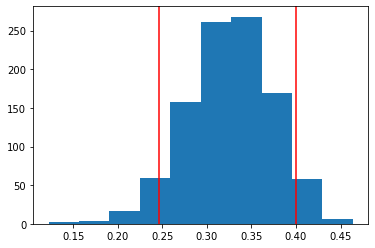

In [12]:
# Compute the CI

boot_ci = np.zeros(2)
    
boot_ci[0] = np.percentile(r2List, 5) # lower bound    
boot_ci[1] = np.percentile(r2List, 95) # upper bound

print("Boot ci:",boot_ci)


plt.hist(r2List)
plt.axvline(x = boot_ci[0], color = 'red')
plt.axvline(x = boot_ci[1], color = 'red')

**Written answer:**
The r-squared computed from the test data is much smaller than the original r-squared. The test data contains cars that have much higher mpg to their relative weights. Thus the model does not accurately predict.